In [1]:
from keras import layers
from keras import regularizers
from keras.layers import Input, Add, Dense, Activation, BatchNormalization, Dropout, Flatten, Conv1D, AveragePooling1D, MaxPooling1D, concatenate, Conv1DTranspose, ZeroPadding1D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from sklearn.model_selection import train_test_split
import random
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform
from matplotlib.pyplot import imshow
import pandas as pd
import os
import openpyxl as xls
from keras import backend as k
import cv2
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
tf.compat.v1.enable_eager_execution()
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

C:\Users\adarabi3\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [2]:
# X = pd.read_csv("ten_speaker_pressure.csv")
# Y= pd.read_csv("ten_speaker_value.csv")
X = pd.read_csv("one_speaker_pressure.csv")
Y= pd.read_csv("one_speaker_value.csv")

In [3]:
X=X[0:20000]
Y=Y[0:20000]
X_data = X.to_numpy()
Y_data = Y.to_numpy()
# Y_data=Y_data[0:10000,0:40]
X_data=X_data.reshape(-1,64,2)
# X_data=X_data[0:50000,0:80,0:3]

print(X_data.shape)
print(Y_data.shape)

(20000, 64, 2)
(20000, 2)


In [4]:
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.15, random_state=42)
# x_train=X_data[0:4000]
# x_test=X_data[4000:5001]
# y_train=Y_data[0:4000]
# y_test=Y_data[4000:5001]
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(17000, 64, 2)
(3000, 64, 2)
(17000, 2)
(3000, 2)


In [1094]:
model_trained=load_model("Sound_ten_speakers2")
model_trained.summary()

Model: "Sound_beaming"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 64, 3)]      0           []                               
                                                                                                  
 conv1d_281 (Conv1D)            (None, 64, 8)        104         ['input_13[0][0]']               
                                                                                                  
 batch_normalization_225 (Batch  (None, 64, 8)       32          ['conv1d_281[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_165 (Activation)    (None, 64, 8)        0           ['batch_normalization

In [1095]:
model2 = Model(model_trained.input, model_trained.layers[-26].output)
model2.summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 64, 3)]      0           []                               
                                                                                                  
 conv1d_281 (Conv1D)            (None, 64, 8)        104         ['input_13[0][0]']               
                                                                                                  
 batch_normalization_225 (Batch  (None, 64, 8)       32          ['conv1d_281[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_165 (Activation)    (None, 64, 8)        0           ['batch_normalization_225[

In [5]:
def identity_block(X, f, filters):
    
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    # First component of main path
    X = Conv1D(filters = F1, kernel_size = 1, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2)(X)
    X = Activation('relu')(X)
    
    X = Conv1D(filters = F2, kernel_size = f, strides = 1, padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2)(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv1D(filters = F3, kernel_size = 1, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2)(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [6]:
def convolutional_block(X, f, filters, s = 2):
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv1D(F1, 1, strides =s, padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2)(X)
    X = Activation('relu')(X)
    # Second component of main path
    X = Conv1D(F2,  kernel_size =f, strides = 1, padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2)(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv1D(F3, kernel_size = 1, strides = 1, padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2)(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv1D(F3, 1, strides = s, padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis =2)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X) 
    
    
    return X

In [8]:
def ResNet_sound(input_shape = (64, 3), classes = 30):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    # X = ZeroPadding1D(3)(X_input)
    X=X_input
    # Stage 1
    X = Conv1D(32, 2, strides = 2,  kernel_initializer = glorot_uniform(seed=0))(X)
    # picture becomes 100*100*16
    X = BatchNormalization(axis = 2)(X)
    X = Activation('relu')(X)
    X = MaxPooling1D(2, strides=2)(X)
    # piture bcomes 25*25*64

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32, 32, 64], s = 1)
    X = identity_block(X, 3, [32, 32, 64])
    X = identity_block(X, 3, [32, 32, 64])
    X = identity_block(X, 3, [32, 32, 64])
    # X = identity_block(X, 3, [32, 32, 64])
    # picture becomes 13*13*16

    # Stage 3
    X = convolutional_block(X, f=3, filters=[64, 128, 128], s=1)
    X = identity_block(X, 3, [64, 128, 128])
    X = identity_block(X, 3, [64, 128, 128])
    X = identity_block(X, 3, [64, 128, 128])
    # X = identity_block(X, 3, [64, 128, 128])
    # picture becomes 7*7*32

    # Stage 4
    X = convolutional_block(X, f=3, filters=[128, 128, 256], s=2)
    X = identity_block(X, 3, [128, 128, 256])
    X = identity_block(X, 3, [128, 128, 256])
    X = identity_block(X, 3, [128, 128, 256])
    # X = identity_block(X, 3, [128, 128, 256])
    # picture becomes 4*4*64

    # Stage 5
    X = convolutional_block(X, f=3, filters=[256, 512, 512],  s=2)
    X = identity_block(X, 3, [256, 512, 512])
    X = identity_block(X, 3, [256, 512, 512])
    # picture becomes 2*2*128

    # Stage 6
    X = convolutional_block(X, f=3, filters=[512, 512, 1024], s=2)
    X = identity_block(X, 3, [512, 512, 1024])
    X = identity_block(X, 3, [512, 512, 1024])
    # X = identity_block(X, 3, [512, 512, 1024])
    # X = identity_block(X, 3, [512, 512, 1024])
    # X = identity_block(X, 3, [512, 512, 1024])
    # X = identity_block(X, 3, [128, 128, 256], stage=6, block='c')
    # picture becomes 1*1*256

    # # Stage 7
    # X = convolutional_block(X, f=3, filters=[16, 16, 16], stage=7, block='a', s=2)
    # X = identity_block(X, 3, [256, 256, 512], stage=7, block='b')
    # # picture becomes 1*1*512

    # Average Pooling
    X = AveragePooling1D(2)(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid',kernel_regularizer=tf.keras.regularizers.l2(0.1))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet_sound')

    return model

In [9]:
model = ResNet_sound(input_shape = (64,2), classes=2)

In [10]:
model.summary()

Model: "ResNet_sound"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 2)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 32, 32)       160         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32)      128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32)       0           ['batch_normalization[

In [1119]:
# def Sound_beaming_pre_trained(input_shape = (64, 3), C1 = 75):
#     X_input = Input(input_shape)
    
#     X = model2(X_input,training=False)
#     # X=X_input



#     X = Flatten()(X)
    
#     # X = Dense(1000, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1))(X)
#     # X = BatchNormalization()(X)
#     # # X=Dropout(0.3)(X)

#     # Y = Dense(1000, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1))(X)
#     # X = BatchNormalization()(Y)
#     # # X=Dropout(0.3)(X)
    
#     # Y = Dense(1000, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1))(X)
#     # X = BatchNormalization()(Y)
#     # # X=Dropout(0.3)(X)

#     # Y = Dense(1000, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1))(X)
#     # X = BatchNormalization()(Y)
#     # # X=Dropout(0.3)(X)

#     # Y = Dense(1000, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1))(X)
#     # X = BatchNormalization()(Y)
#     # # X=Dropout(0.3)(X)

#     # Y = Dense(1000, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1))(X)
#     # X = BatchNormalization()(Y)
#     # # X=Dropout(0.3)(X)

#     # Y = Dense(1000, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1))(X)
#     # X = BatchNormalization()(Y)
#     # # X=Dropout(0.3)(X)
 
#     Y = Dense(1000, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1))(X)
#     # X = BatchNormalization()(Y)
#     # # X=Dropout(0.3)(X)
 

#     Y = Dense(1000, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1))(X)
#     # X = BatchNormalization()(Y)
#     # # # X=Add()([X,Y])
    
#     Y = Dense(1000, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1))(X)
#     # X = BatchNormalization()(Y)


#     # Y = Dense(1000, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1))(X)
#     # X = BatchNormalization()(Y)
#     # # X=Dropout(0.5)(X)

#     X = Dense(C1*1, activation='sigmoid',kernel_regularizer=tf.keras.regularizers.l2(0.1))(X)
   
#     model = Model(inputs = X_input, outputs = X, name='Sound_last_layer')

#     return model



In [1103]:
model2.trainable = False

In [11]:
learn_rate=0.01
rate=1/50
def decay_fun(epoch):
    lrate=learn_rate*np.exp(-rate*epoch)
    if lrate<5e-4:
        lrate=5e-4
    return lrate

In [12]:
lerate=LearningRateScheduler(decay_fun)
callback_list=[lerate]

In [1121]:
# model = Sound_beaming_pre_trained(input_shape = (64,3), C1=30)

In [1122]:
model.summary()

Model: "ResNet_sound"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_199 (InputLayer)         [(None, 64, 3)]      0           []                               
                                                                                                  
 zero_padding1d_1 (ZeroPadding1  (None, 70, 3)       0           ['input_199[0][0]']              
 D)                                                                                               
                                                                                                  
 conv1d_82 (Conv1D)             (None, 35, 64)       448         ['zero_padding1d_1[0][0]']       
                                                                                                  
 batch_normalization_603 (Batch  (None, 35, 64)      256         ['conv1d_82[0][0]']   

In [13]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [14]:
model.compile(tf.keras.optimizers.SGD(), loss=tf.keras.losses.MeanAbsoluteError(), metrics=[coeff_determination])
# model.compile(tf.keras.optimizers.Adam(clipnorm=5), loss=tf.keras.losses.MeanSquaredError(), metrics=[coeff_determination])
# model.compile(tf.keras.optimizers.Adam(), loss= "binary_crossentropy", metrics=['accuracy'])



In [17]:
prediction=model.fit(x_train,y_train,epochs=400,batch_size=256, callbacks=callback_list,validation_data=(x_test,y_test))
# prediction=model.fit(x_train,y_train,epochs=2000,batch_size=32, callbacks=callback_list)


Epoch 1/400
67/67 [==============================] - 38s 572ms/step - loss: 0.0500 - coeff_determination: 0.9738 - val_loss: 0.0289 - val_coeff_determination: 0.9941 - lr: 0.0100
Epoch 2/400
67/67 [==============================] - 40s 590ms/step - loss: 0.0439 - coeff_determination: 0.9797 - val_loss: 0.0427 - val_coeff_determination: 0.9824 - lr: 0.0098
Epoch 3/400
67/67 [==============================] - 40s 595ms/step - loss: 0.0477 - coeff_determination: 0.9759 - val_loss: 0.0545 - val_coeff_determination: 0.9698 - lr: 0.0096
Epoch 4/400
67/67 [==============================] - 40s 605ms/step - loss: 0.0457 - coeff_determination: 0.9769 - val_loss: 0.0285 - val_coeff_determination: 0.9929 - lr: 0.0094
Epoch 5/400
67/67 [==============================] - 42s 622ms/step - loss: 0.0438 - coeff_determination: 0.9786 - val_loss: 0.0516 - val_coeff_determination: 0.9687 - lr: 0.0092
Epoch 6/400
67/67 [==============================] - 42s 623ms/step - loss: 0.0430 - coeff_determination:

In [20]:
preds = model.evaluate(x_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

94/94 [==============================] - 2s 17ms/step - loss: 0.0101 - coeff_determination: 0.9995
Loss = 0.01009237952530384
Test Accuracy = 0.9995375871658325


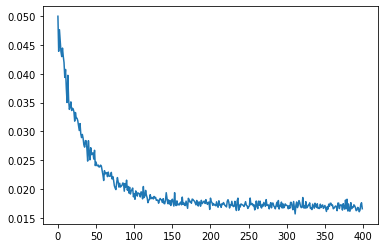

In [27]:
plt.plot(prediction.history["loss"])

In [25]:
NN=12544
X_dataa=X_data[NN]
X_dataa=X_dataa.reshape(1,64,2)
print(X_dataa.shape)
q=model.predict(X_dataa)
# mse = tf.keras.losses.MeanAbsoluteError()
# error=mse(q, Y_data[NN]).numpy
print(q)
print(Y_data[NN])
# data_y_print=Y_data[NN]
# print(data_y_print)
# top20=np.argsort(q[0])[:-21:-1]
# print(top20)

# new_vec=np.zeros(100)

# for val in top20:
#     new_vec[val]=1

# print(new_vec)

# print(new_vec-Y_data[NN])


(1, 64, 2)
[[0.4106475 0.9942758]]
[0.4 1. ]


In [26]:
model.save('Sound_one_speakers_detection')

INFO:tensorflow:Assets written to: Sound_one_speakers_detection\assets
